In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision import datasets

# Get MNIST data

In [2]:
def generate_pair_sets():
    data_dir = os.environ.get('PYTORCH_DATA_DIR')
    if data_dir is None:
        data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_features = train_set.train_data.view(-1, 1, 28, 28).float()
    train_target = train_set.train_labels
    #train_features = torch.functional.F.avg_pool2d(train_features, kernel_size = 2)

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_features = test_set.test_data.view(-1, 1, 28, 28).float()
    test_target = test_set.test_labels
    #test_features = torch.functional.F.avg_pool2d(test_features, kernel_size = 2)

    return train_features, train_target, test_features, test_target

In [3]:
import warnings
warnings.filterwarnings('ignore')
train_features, train_target, test_features, test_target = generate_pair_sets()

In [4]:
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


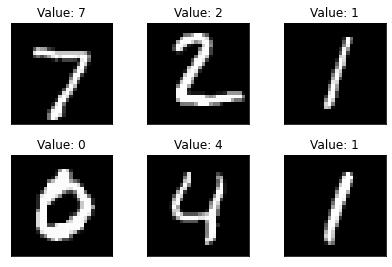

In [5]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(test_features[i].reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title("Value: {}".format(test_target[i]))  
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

# Homemade framework

In [6]:
%load_ext autoreload
%autoreload 2
from homemade_framework import framework as NN

# Models parameters

In [7]:
# number of epoch
num_epochs = 10
# batch size to compute mini-batch
batch_size = 100
# number of pixels in the image 
input_size = 28*28
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.01
# hidden size
hidden_size = 128
# p dropout
p_dropout = 0
# learning rate decay
LRD = False

# Train homemade CNN model

In [8]:
# convert data to numpy array
nb=3000
train_features_np, train_target_np = train_features.numpy()[0:nb], train_target.numpy()[0:nb]
test_features_np, test_target_np = test_features.numpy(), test_target.numpy()

# Build the model
kernel_size = 3
in_channels = 1
out_channels = 2
data_size = train_features_np.shape[2]
nb_maxpool = 1
out_first_conv = (data_size - kernel_size + 1) // (2*nb_maxpool) - kernel_size + 1

# Build the model
cnn_model = NN.Sequential([NN.Convolution(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
                           NN.LeakyReLU(), NN.MaxPooling2D(2),
                           NN.Convolution(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size),
                           NN.LeakyReLU(), NN.Flatten(), NN.BatchNorm(),
                           NN.Linear((out_first_conv**2)*out_channels, hidden_size), NN.LeakyReLU(), NN.BatchNorm(),
                           NN.Linear(hidden_size, num_class), NN.Softmax()], NN.LossMSE())
# Set the learning rate
cnn_model.set_Lr(learning_rate)
# Print model's parameters
cnn_model.print(print_color=True)

Model description: Linear in green, Activation in blue, Loss in magenta, Softmax in red, Flatten in Gray, Convolution in Cyan, BatchNormalization in Black, MaxPooling2D in Yellow, AveragePooling2D in highlight
	Convolution feature maps: 2, kernel size: (2, 1, 3, 3)
	LeakyReLU activation, a=0.01
	Max Pooling layer, size: 2
	Convolution feature maps: 2, kernel size: (2, 2, 3, 3)
	LeakyReLU activation, a=0.01
	Flatten function
	Batch normalization function: a=1, b=0
	Linear layer shape: [242, 128]
	LeakyReLU activation, a=0.01
	Batch normalization function: a=1, b=0
	Linear layer shape: [128, 10]
	Softmax function
	MSE


In [ ]:
NN.train(cnn_model, num_epochs, train_features_np, train_target_np, test_features_np, test_target_np, batch_size)

Before training: Epoch: 0, Train Error: 89.7333%,        Test Error: 89.9800%, Loss  0.0000


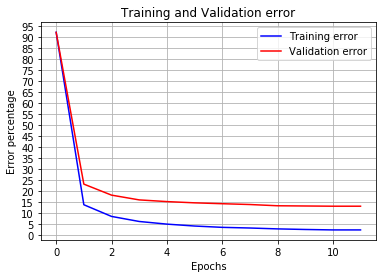

In [9]:
NN.learning_curves(cnn_model)

# Save then load model to deploy it

In [11]:
cnn_model.save('models/cnn/')

In [12]:
NN.print_current_results(0, cnn_model, train_features_np, train_target_np,
                         test_features_np, test_target_np, 0)

Epoch: 0, Train Error: 2.2667%,        Test Error: 13.0333%, Loss  0.0000


In [13]:
deploy_model = NN.Sequential([NN.Convolution(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
                              NN.LeakyReLU(), NN.MaxPooling2D(2),
                              NN.Convolution(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size),
                              NN.LeakyReLU(), NN.Flatten(), NN.BatchNorm(),
                              NN.Linear((out_first_conv**2)*out_channels, hidden_size), NN.LeakyReLU(), NN.BatchNorm(),
                              NN.Linear(hidden_size, num_class), NN.Softmax()], NN.LossMSE())

In [14]:
deploy_model.load('models/cnn/')

In [15]:
NN.print_current_results(0, deploy_model, train_features_np, train_target_np,
                         test_features_np, test_target_np, 0)

Epoch: 0, Train Error: 2.2667%,        Test Error: 13.0333%, Loss  0.0000


# Comparison with FCN

In [21]:
# number of pixels in the image 
input_size = 28*28
# number of hidden neurons
hidden_size = 40

# convert data to numpy array
nb=3000
train_features_np, train_target_np = train_features.numpy()[0:nb], train_target.numpy()[0:nb]
test_features_np, test_target_np = test_features.numpy()[0:nb], test_target.numpy()[0:nb]
train_features_np = train_features_np.reshape([train_features_np.shape[0], np.prod(train_features_np.shape[1:])])
test_features_np = test_features_np.reshape([test_features_np.shape[0], np.prod(test_features_np.shape[1:])])

# Build the model
fcn_model = NN.Sequential([NN.Linear(input_size, hidden_size), NN.LeakyReLU(), NN.BatchNorm(),
                       NN.Linear(hidden_size, hidden_size), NN.LeakyReLU(), NN.BatchNorm(),
                       NN.Linear(hidden_size, num_class), NN.Softmax()], NN.LossMSE())
# Set the learning rate
fcn_model.set_Lr(learning_rate)
# Print model's parameters
fcn_model.print(print_color=True)

NN.train_homemade_model(fcn_model, num_epochs, train_features_np, train_target_np, test_features_np, test_target_np, batch_size)

Model description: Linear in green, Activation in blue, Loss in magenta, Softmax in red, Flatten in Gray, Convolution in Cyan, BatchNormalization in Black, MaxPooling2D in Yellow, AveragePooling2D in highlight
	Linear layer shape: [784, 40]
	LeakyReLU activation, a=0.01
	Batch normalization function: a=1, b=0
	Linear layer shape: [40, 40]
	LeakyReLU activation, a=0.01
	Batch normalization function: a=1, b=0
	Linear layer shape: [40, 10]
	Softmax function
	MSE
Before training: Epoch: 0, Train Error: 85.4333%,        Test Error: 84.6667%, Loss  0.0000
Epoch: 1, Train Error: 34.8000%,        Test Error: 42.1000%, Loss  202.5826
Epoch: 2, Train Error: 21.3000%,        Test Error: 29.0667%, Loss  126.5436
Epoch: 3, Train Error: 14.9000%,        Test Error: 23.4667%, Loss  92.3390
Epoch: 4, Train Error: 12.6000%,        Test Error: 21.0333%, Loss  73.3680
Epoch: 5, Train Error: 10.8000%,        Test Error: 19.4667%, Loss  62.4692
Epoch: 6, Train Error: 9.5000%,        Test Error: 18.8000%, L

In [22]:
print("Number of parameters: \n\t cnn: {} \n\t fcn: {}".format(cnn_model.getParametersCount(), fcn_model.getParametersCount()))

Number of parameters: 
	 cnn: 32456 
	 fcn: 33454


Same number of parameters but the scores are better for the CNN. Indeed, CNN is more adapted to images.